# Deep Learning & Applied AI

# Tutorial 3: Linear models and Pytorch Datasets

In this tutorial, we will cover:

- Linear models
- Pytorch Dataset and DataLoader

Based on original material by Dr. Luca Moschella (moschella@di.uniroma1.it) and Dr. Antonio Norelli (norelli@di.uniroma1.it)

Course:

- Website and notebooks will be available at https://erodola.github.io/DLAI-s2-2025/

#### Instructions
We encourage you to form small groups of 2-3 people to read and discuss the notebooks together.

Run the code and play with it! It is very easy to edit the code locally and make small experiments. Try whatever comes to your mind, this is the best way to learn! Python notebooks are designed to be used in this way, that's why we chose them for the DLAI lab sessions.

There will be some exercises, try to do them by yourself, and when everyone in your group has finished, compare the solutions with each other.

When something is not clear or you have a question, raise your hand and we will come to you, or directly approach us.

Some sections in the notebooks are marked with 📖. This is additional content for further reading outside of class. You may want to go through it at home or during class if you finish early. (Some sections are "more optional" than others, those marked with more books 📖📖)

Let's start!

### Import dependencies

In this notebook you will discover **Plotly**, a powerful plotting library (there are many [visualization libraries](https://pyviz.org/overviews/index.html) for Python).
Effectively communicating your findings through plots and visualizations is an essential part of any scientific or engineering project.
Plotly is a modern library that makes interactive plots very easy to produce, and is very popular also outside of the DL community.

[Here](https://plot.ly/python/) you can find its documentation.

In [1]:
import torch
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### A note on reproducibility

As mentioned in the previous notebooks, we are going to ensure that all the RNGs used in different parts of this notebook produce the same sequence of numbers each time.

In [2]:
# Reproducibility stuff

import random
torch.manual_seed(42)      # PyTorch CPU
np.random.seed(42)         # NumPy
random.seed(0)             # Python built-in
torch.cuda.manual_seed(0)  # PyTorch GPU

For some operations, cuDNN (NVIDIA's library for deep neural networks) uses algorithms that can produce different results on different runs, *even* with the same inputs and the same seed. Below we set `deterministic = True`, forcing cuDNN to use deterministic algorithms where possible. This might limit cuDNN to a subset of algorithms that might not be  the most efficient, but will produce the same results across different runs.

In [3]:
torch.backends.cudnn.deterministic = True

Finally, when `benchmark = True`, cuDNN will automatically find the most efficient algorithms for your specific operations based on your network architecture and input sizes. This can greatly improve performance. However, since the selection of algorithms might change from one run to another, this can lead to non-deterministic behavior. Setting it to `benchmark = False` prevents cuDNN from dynamically selecting algorithms, thus improving reproducibility at the cost of potential performance gains.

In [4]:
torch.backends.cudnn.benchmark = False

Enough about reproducibility, let's move on to the meat!

## Linear models
Today we'll work with **linear models**. Don't underestimate their power! Linear models are simple, but they are at the heart of several effective pipelines. They will provide solid baselines for our experiments at the very least, and are a useful tool to study more advanced topics in modern deep learning.

### The regression problem
#### The general definition
We observe a phenomenon $\mathcal{P}$ where a variable of interest $t$ depends on another variable $x$.

**Problem**: Given a set of $N$ paired observations $(x, t)$, $\mathbf{D}=\{(x_1, t_1),...,(x_N, t_N)\}$, and a new *input* instance $x_i$, find the corresponding *target* $t_i$.

#### Our workspace

In our workspace, the underlying law governing our phenomenon $\mathcal{P}$ links $t$ to a $x \in [0,1]$ through a $\sin$ function.
For our purposes, we are going to synthetically generate a set of observations --our *dataset*-- following this rule:

$$t=\sin(2\pi x) + 0.1\epsilon \;\;\;\;\;\;\;\;\; \epsilon \sim \mathcal{N}(0,1)$$

where $\sim \mathcal{N}(0,1)$ means "*sampled from a gaussian distribution with $\mu=0$ and $\sigma=1$*".

In this way, we are simulating the measurement process of any phenomenon: there is a global and general regularity (that we wish to discover) but all observations are plagued by uncertainty, here modeled with gaussian noise. Uncertainty usually comes from the finite precision of our measuring instrument, but may also be due to sources of variability we do not care about. Sometimes the problem we are tackling is intrinsically stochastic --such as measurements in quantum mechanics or idealized scenarios like the multi-armed bandit-- and we want to figure out just the non-stochastic part of the underlying rule.

This is our dataset:

In [5]:
x = np.random.rand(10)
t = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(10)

In [6]:
fig = px.scatter(x=x, y=t)
fig.show()

It seems we have very little to work with! Just a handful of noisy points.

How is it possible to devise a rule $f$ that is valid in general --i.e. for all the *infinite* points $x_i$ between 0 and 1 shall occur $t_i=f(x_i)$-- from such a *finite* set of observations?

If we collect just 10 points and each of them agrees with a precise rule, why does that give us *any grounds* --even probabilistic grounds-- to expect the 11[$^{st}$](https://translate.google.com/translate?sl=it&tl=en&u=https://it.wikipedia.org/wiki/Tacchino_induttivista) point to follow the same rule?

This is the essence of the so called [*Problem of induction*](https://ar5iv.labs.arxiv.org/html/1108.1791#S7) raised by David Hume more than two centuries ago. Still today this problem is at the core of the philosophical debate on the nature of knowledge.

### Where to restart from?

We will take a very pragmatic point of view. Even if induction cannot be justified in general, we note that "often it seems to work". Therefore we proceed with our quest to find $f$.

First of all, we observe that the quality of our guess $f$ depends crucially on how much information about the phenomenon $\mathcal{P}$ we are given in advance, i.e. what **priors** do we have.



**EXERCISE**: Suppose you have to guess this general rule $f$ to make predictions for new $x_i \in [0,1]$. In which of the following scenarios would you like to find yourself to make the most accurate predictions?

Write down a ranking from best to worst scenario, and then compare your ranking with those of your neighbors.

For each scenario below, we give you a description of the available priors together with a plot.


> **Scenario A**
>
> *priors:*
> - 20 observations $(x_i,t_i)$ in the interval $[0,1]$ affected by a gaussian noise $0.1*\epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$.

> **Scenario B**
>
> *priors:*
> - 20 observations $(x_i,t_i)$ in the interval $[0,1]$ affected by a gaussian noise $0.5*\epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$

> **Scenario C**
>
> *priors:*
> - 40 observations $(x_i,t_i)$ in the interval $[0,1]$ affected by a gaussian noise $0.1*\epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$

> **Scenario D**
>
> *priors:*
> - 100 observations $(x_i,t_i)$ in the interval $[0,0.3]$ affected by a gaussian noise $0.1*\epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$

> **Scenario E**
>
> *priors:*
> - 10 observations $(x_i,t_i)$ in the interval $[0,1]$ affected by a gaussian noise $0.1*\epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$
> - you know that $f$ is in the form $f(x)=\sin(kx)$ with $k\in \mathbb{R}$


In [7]:
# @title Scenario plots

xA = np.random.rand(20)
tA = np.sin(2 * np.pi * xA) + 0.1 * np.random.randn(20)

xB = np.random.rand(20)
tB = np.sin(2 * np.pi * xB) + 0.5 * np.random.randn(20)

xC = np.random.rand(40)
tC = np.sin(2 * np.pi * xC) + 0.1 * np.random.randn(40)

xD = np.random.rand(100) * 0.3
tD = np.sin(2 * np.pi * xD) + 0.1 * np.random.randn(100)

xE = np.random.rand(10)
tE = np.sin(2 * np.pi * xE) + 0.1 * np.random.randn(10)

fig = make_subplots(
    rows=1, cols=5,
    subplot_titles=("Scenario A", "Scenario B", "Scenario C", "Scenario D", "Scenario E"))

fig.add_trace(go.Scatter(x=xA, y=tA, mode='markers', marker=dict(color="mediumpurple")),
              row=1, col=1)

fig.add_trace(go.Scatter(x=xB, y=tB, mode='markers', marker=dict(color="mediumpurple")),
              row=1, col=2)

fig.add_trace(go.Scatter(x=xC, y=tC, mode='markers', marker=dict(color="mediumpurple")),
              row=1, col=3)

fig.add_trace(go.Scatter(x=xD, y=tD, mode='markers', marker=dict(color="mediumpurple")),
              row=1, col=4)

fig.add_trace(go.Scatter(x=xE, y=tE, mode='markers', marker=dict(color="crimson")),
              row=1, col=5)

fig.update_xaxes(title_text="x", range=[0, 1])
fig.update_yaxes(title_text="", range=[-1.7, 1.7])
fig.update_layout(showlegend=False)

fig.show()

If you want to learn more, [here](http://bit.ly/3BLUE1BROWN2TWY9iI) you can find a nice discussion about an analogous exercise:
> Three Amazon resellers offer a book at essentially the same price. These are their ratings:
>
> - 100% positive out of 10 reviews
> - 96% positive out of 50 reviews
> - 93% positive out of 200 reviews
>
> Which rating is better?

> **EXERCISE (optional)**: You probably realized that in the previous exercise you wanted to be in the scenario with the largest amount of relevant information about the phenomenon $\mathcal{P}$. Now a tricky question: the dataset of which scenario, A or B, contains more *absolute* information? (i.e. Shannon information)
>
>Answer [here](http://bit.ly/VeritasiumRandom3b0rPBe), or more directly [here](https://en.wikipedia.org/wiki/Quantities_of_information#Self-information).

### Being linear in the parameters does not mean linear in the input

In this tutorial we will restrict our search of $f$ among parametrized functions $f_\theta$ that depend *linearly* on their finite set of parameters $\theta = \{a,b,c,...\}$.

Possible choices of $f$ are
- $f_1(x) = ax + b$
- $f_2(x) = ax^2 + bx + c$
- $f_3(x) = a \sin(2 \pi x) + bx + c$

In [8]:
# @title Some random plots of these linear models


x_funcs = np.arange(0., 1.1, 2./51)
theta_funcs = np.random.randn(10, 3)

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("f1", "f2", "f3"))

for a, b in theta_funcs[:,:2]:
    fig.add_trace(go.Scatter(x=x_funcs, y=a*x_funcs + b, mode='lines'),
                row=1, col=1)

for a, b, c in theta_funcs:
    fig.add_trace(go.Scatter(x=x_funcs, y=a*x_funcs**2 + b*x_funcs + c, mode='lines'),
                row=1, col=2)

for a, b, c in theta_funcs:
    fig.add_trace(go.Scatter(x=x_funcs, y=a*np.sin(2 * np.pi * x_funcs) + b*x_funcs + c, mode='lines'),
                row=1, col=3)

for i in range(3):
    fig.add_trace(go.Scatter(x=x, y=t, mode='markers', marker=dict(color="mediumpurple")),
                row=1, col=i + 1)

fig.update_xaxes(title_text="x", range = [0,1])
fig.update_yaxes(title_text="t", range = [-2,2])
fig.update_layout(showlegend=False)

fig.show()

### Loss landscapes

Let's focus now on the simple $f(x) = ax + b$.
Given our dataset $(\mathbf{x}, \mathbf{t})$ we will choose the parameters $a$ and $b$ that minimize a global error $E$, also known as *loss*.

The standard choice for $E$ in a regression problem is the Mean Squared Error, defined as:

$$E(\theta) = \frac{1}{N} \sum_{i=1}^N(f_\theta(x_i) - t_i)^2$$

Notice that apart from normalization factors, the MSE corresponds to the squared $L_2$ norm of the residual vector, namely $E=\|f_\theta(\mathbf{x}) - \mathbf{t}\|_2^2$ (here $f_\theta$ operates element-wise).

Let's now compute the MSE **loss landscape** for our dataset, so that we can visualize it. The landscape is simply defined as the value of the loss function computed over a subset of the parameter domain.

In [9]:
x

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

In [10]:
t

array([ 0.66219959, -0.25048944, -1.03994878, -0.62751823,  0.85485734,
        0.6392487 ,  0.1844109 , -0.80143233, -0.69472173, -0.93407575])

In [11]:
resolution = 51

mse_losses = np.empty((resolution, resolution))
a_range = np.linspace(-5, 5, resolution)
b_range = np.linspace(-5, 5, resolution)

for i, a in enumerate(a_range):
    for j, b in enumerate(b_range):
        y_pred = a * x + b
        residuals = t - y_pred
        loss = np.einsum('i,i->', residuals, residuals)
        mse_losses[i][j] = loss

# let's ignore the division by N for this exercise

>**EXERCISE** Vectorize the piece of code above. i.e. the two `for` cycles should disappear.

In [12]:
# ✏️ your code here

grid_a, grid_b = torch.meshgrid(torch.tensor(a_range), torch.tensor(b_range), indexing='ij')
Theta = torch.stack((grid_a, grid_b), dim=-1)
Theta.shape

torch.Size([51, 51, 2])

In [13]:
X = torch.stack((torch.tensor(x), torch.ones(len(x))), dim=-1)
X.shape

torch.Size([10, 2])

In [14]:
Y_pred = Theta @ X.T
Y_pred.shape

torch.Size([51, 51, 10])

In [15]:
error = Y_pred - t[None, None, :]
error.shape

torch.Size([51, 51, 10])

In [16]:
loss = torch.sum(error**2, dim=2)
loss.shape

torch.Size([51, 51])

In [17]:
np.allclose(mse_losses, loss)

True

In [18]:
# @title 👀 Solution (without einsum)

Y_pred = x[None, None, :] * a_range[:, None, None] + b_range[None, :, None] # let broadcasting do the job!
R = t[None, None, :] - Y_pred
L = np.sum(R**2, axis=2)
np.allclose(L, mse_losses)

True

In [19]:
# @title 👀 Solution (with einsum)

a_times_x = np.einsum('i,j->ij', a_range, x)
Y_pred = a_times_x[:, :, None] + b_range[None, None, :]
residuals = t[None, :, None] - Y_pred
L = np.einsum('ijk->ik', residuals ** 2)
np.allclose(L, mse_losses)

True

In [20]:
# @title MSE loss landscape plot
fig = go.Figure(data=[go.Surface(z=mse_losses, x=a_range, y=b_range)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(
    title="MSE loss landscape",
    scene = dict(
                xaxis_title='a',
                yaxis_title='b',
                zaxis_title='loss')
)


fig.show()

Look at the [convexity](https://en.wikipedia.org/wiki/Convex_function) of the MSE loss. Can you do the linear regression by sight hovering the mouse over it?

>**EXERCISE** Visualize the **loss landscape** of other loss choices, such as the $L_1$ norm of the residual vector ($\|f_\theta(\mathbf{x}) - \mathbf{x}\|_1)$ (absolute error) or the $L_{50}$ norm. Are these still convex?  

In [21]:
# ✏️ your code here

Y_pred = a_range[:, None, None] * x[None, None, :] + b_range[None, :, None]
residuals = np.abs(Y_pred - t[None, None, :])
losses = (np.sum(residuals, axis=-1)) / Y_pred.shape[-1]

In [22]:
# @title 👀 Solution (see how we did the slider!) { run: "auto" }

p = 1  #@param {type:"slider", min:1, max:50, step:1}

predictions = a_range[:, None, None] * x[None, None, :]  + b_range[None, :, None]
residuals = np.abs(t[None, None, :] - predictions) ** p
losses = (residuals.sum(-1) ** (1/p)) / predictions.shape[-1]


fig = go.Figure(data=[go.Surface(z=losses, x=a_range, y=b_range)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(
    title=f"L{p} landscape",
    scene = dict(
                xaxis_title='a',
                yaxis_title='b',
                zaxis_title='loss')
)
fig.show()

### "Tear down this loss[!](https://youtu.be/IguMXrgfrg8)"

Now we will explicitily compute the parameters $\theta$ for several polynomial fits, defined in matrix notation as:

![polyfit matrix notation](https://drive.google.com/uc?export=view&id=1e4AsSC00ivIXW4c35VNLladTcCTY4dpL)

As seen in the lecture, we can analytically find the parameters $\theta$ that minimize the MSE loss by solving a linear system:

$$\theta = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}$$

Let's do it for a 3-degree polynomial fit, this time using pytorch instead of numpy.

In [23]:
# Poly3 fit
y = torch.from_numpy(t)
x_tens = torch.from_numpy(x)

X = torch.ones((y.shape[0], 4), dtype=torch.float64)  # double precision is needed for this calculation, especially with high degree polyfits
X[:,0] = x_tens ** 3
X[:,1] = x_tens ** 2
X[:,2] = x_tens

>**EXERCISE**: complete the code

In [24]:
# ✏️ your code here (look at the formula above!)
theta = (X.T @ X).inverse() @ X.T @ y

In [25]:
# @title 👀 Solution (without einsum)

theta = torch.inverse(X.t() @ X) @ X.t() @ y

In [26]:
# @title 👀 Solution (with einsum)

temp_inverse = torch.inverse(torch.einsum('ij,jk->ik', X.t(), X))  # or torch.einsum('ji,jk->ik', X, X)
theta = torch.einsum('ij,jk,k->i', temp_inverse, X.t(), y)

In [27]:
# @title 👀 Solution (numerically stable)

# The equation for theta requires us to solve a linear system.
# Instead of explicitly computing a matrix inverse and then multiplying, a more
# efficient and stable way is to use torch.linalg.solve(), which is designed to
# handle this task more appropriately.

theta = torch.linalg.solve(X.t() @ X, X.t() @ y)

In [28]:
#@title 3-degree polynomial fit

a, b, c, d = theta.numpy()
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=t, name='dataset', mode='markers', marker=dict(color="mediumpurple")))
fig.add_trace(go.Scatter(x=x_funcs, y=np.sin(2*np.pi*x_funcs), name='ground truth', mode='lines', line=dict(color="lightgreen")))
fig.add_trace(go.Scatter(x=x_funcs, y=a*x_funcs**3 + b*x_funcs**2 + c*x_funcs + d, name='poly3 fit', mode='lines', line=dict(color="lightsalmon")))
fig.update_xaxes(title_text="x", range = [0,1])
fig.update_yaxes(title_text="t", range = [-1.5,1.5])
fig.show()

Let's now compare several polynomial fits with different degrees.

Play a bit with the degrees while taking a look at the coefficients $\theta$.

Which one is the best in *your judgement*?
Which one is the best according to the MSE loss?

An evergreen reminder that here fits well:
> **be skeptical!** Especially about the numbers that should tell us if the results we get are good or bad. Are these really evaluating what should be evaluated?

In [29]:
# @title Polynomial fits (press play at least once to trigger the self-update) { run: "auto" }

degree = {}
deg_a = 2  #@param {type:"slider", min:0, max:15, step:1}
deg_b = 4  #@param {type:"slider", min:0, max:15, step:1}
deg_c = 7 #@param {type:"slider", min:0, max:15, step:1}

degree[0], degree[1], degree[2], degree[3] = deg_a, deg_b, deg_c, 18

max_degree = max(degree.values())
y = torch.from_numpy(t)
X_full = torch.ones((y.shape[0], max_degree + 1), dtype=torch.float64)  # double precision is needed for this calculation!
for i in range(max_degree):
    X_full[:,i] =  torch.from_numpy(x) ** (max_degree - i)

theta_collection = {}

for i in range(len(degree)):
    X = X_full[:,-(degree[i] + 1):]
    temp_inverse = torch.inverse(torch.einsum('ij,jk->ik', X.t(), X))
    theta_collection[i] = torch.einsum('ij,jk,k->i', temp_inverse, X.t(), y)

fig = make_subplots(
    rows=1, cols=len(degree),
    subplot_titles=(f"poly{degree[0]} fit", f"poly{degree[1]} fit", f"poly{degree[2]} fit", f"poly{degree[3]} fit"))

x_funcs = np.arange(0,1,1./100)
y_funcs = {}
for i in range(len(degree)):
    theta_funcs = theta_collection[i].numpy()
    X_funcs = np.ones((x_funcs.shape[0], degree[i] + 1), dtype=np.float64)
    for j in range(degree[i]):
        X_funcs[:,j] =  x_funcs ** (degree[i] - j)
    y_funcs[i] = np.einsum('ij,j->i', X_funcs, theta_funcs)
    coefficients_string = '<br><br><br>' + '<br>'.join([c + f': {np.round(theta_funcs[i], decimals=2)}' for i, c in enumerate('abcdefghijklmnopqrstuvwxyz'[:len(theta_funcs)])])

    fig.add_trace(go.Scatter(x=x, y=t, mode='markers', marker=dict(color="mediumpurple")), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=x_funcs, y=np.sin(2*np.pi*x_funcs), mode='lines', line=dict(color="lightgreen")), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=x_funcs, y=y_funcs[i], mode='lines', line=dict(color="lightsalmon")), row=1, col=i + 1)
    fig.update_xaxes(title_text="x" + coefficients_string, range = [0,1], row=1, col=i+1)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="t", range = [-5,5])
fig.update_layout(height=700, width=1300, title_text="Polynomial fits and their coefficients")
fig.show()

Nevertheless you should find *evidence* to support your judgement. Our intuition right now is that "High-degree polynomial fits lead to a high generalization error for this dataset", how can we test it?
As you have learnt in the lecture, a useful study you can perform consists in evaluating the MSE loss on a *test set*, i.e., on samples not used for training.

Such as the ones that are going to magically appear in the next cell.

In [30]:
x_test = np.random.rand(10)
t_test = np.sin(2 * np.pi * x_test) + 0.1 * np.random.randn(10)

> **EXERCISE**: Do a nice plot entitled "MSE loss **vs** degree of the polynomial fit" that shows the trends of the training set and the test set.

In [31]:
# ✏️ your code here

degree = 20

def get_poly_matrix(x, deg):

    X = torch.ones((y.shape[0], deg + 1), dtype=torch.float64)  # double precision is needed for this calculation, especially with high degree polyfits
    
    for d in range(deg + 1):
        X[:, deg - d] = x ** d
    
    return X

losses = []

for deg in range(degree):
    X = get_poly_matrix(x_tens, deg)
    y = torch.from_numpy(t)
    theta = torch.linalg.solve(X.t() @ X, X.t() @ y)
    x = torch.from_numpy(x_test)
    y = torch.from_numpy(t_test)
    x = get_poly_matrix(x, deg)
    pred  = x @ theta
    error = (pred - y) ** 2
    loss  = torch.sum(error) / error.shape[-1]
    
    losses.append(float(loss))


# Gradi del polinomio
degrees = list(range(degree))

# Creazione del grafico interattivo
fig = go.Figure()
fig.add_trace(go.Scatter(x=degrees, y=losses, mode='lines+markers',
                         line=dict(color='red', width=3),
                         marker=dict(size=8, color='blue', symbol='circle'),
                         name='MSE Loss'))

# Layout estetico
fig.update_layout(title='MSE Loss vs Degree of Polynomial',
                  xaxis_title='Degree of Polynomial',
                  yaxis_title='MSE Loss',
                  template='plotly_dark',
                  hovermode='x unified',
                  font=dict(size=14),
                  yaxis=dict(type='log', rangemode='tozero'))

fig.show()

**NOTE**

Typically, when you are designing a learning model, you would get all the available data at the beginning. Then, you split this data into training, validation, and test sets.

To recap:

* **Training set**: the data we use to estimate our model's parameters.
* **Validation set**: new data we use to evaluate our model, and possibly tune its hyperparameters.
* **Test set**: new data we use to evaluate the final model.

### Data leakage

> ⚠️ Using the test set to tune your model's design and hyperparameters is not just cheating: it is *conceptually wrong*.
>
> In the real world, you almost never have access to the test set. For example, ChatGPT has never seen the crazy prompts we give it, but it still works well. Our input forms ChatGPT's test set. We can conclude that ChatGPT generalizes well to unseen data.

### Regularization
Still, it is not always desirable to work with simple models with few parameters.

Think about the true link between the input variable $x$ and the target variable $t$, it is through a $\sin$ function.
And a $\sin$ function written in a polynomial basis (i.e. [its Taylor series](https://www.wolframalpha.com/input?i=taylor+series+sin+x)) contains terms of *every* odd degree, i.e. infinite terms. Our approximation of the ground truth function should benefit from high order terms, since they are *needed* to express a $\sin$ function.

We want to have many parameters, and we want them to do the right thing: to not overfit.
This is why we need **regularizers**.

Let's start with the simplest and most universal regularizer, *more data*.

In [32]:
# @title Regularized polynomial fits: more data (again: play at least once) { run: "auto" }

training_dataset_size = 75  #@param {type:"slider", min:1, max:100, step:1}
temp_x, temp_t = x, t
x = np.random.rand(training_dataset_size)
t = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(training_dataset_size)

deg_1 = 2  #@param {type:"slider", min:0, max:15, step:1}
deg_2 = 6  #@param {type:"slider", min:0, max:15, step:1}
deg_3 = 13  #@param {type:"slider", min:0, max:15, step:1}

degree = {}
degree[0], degree[1], degree[2] = deg_1, deg_2, deg_3

max_degree = max(degree.values())
y = torch.from_numpy(t)
X_full = torch.ones((y.shape[0], max_degree + 1), dtype=torch.float64)  # double precision is needed for this calculation!
for i in range(max_degree):
    X_full[:,i] =  torch.from_numpy(x) ** (max_degree - i)

theta_collection = {}

for i in range(3):
    X = X_full[:,-(degree[i] + 1):]
    temp_inverse = torch.inverse(torch.einsum('ij,jk->ik', X.t(), X))
    theta_collection[i] = torch.einsum('ij,jk,k->i', temp_inverse, X.t(), y)

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(f"poly{degree[0]} fit", f"poly{degree[1]} fit", f"poly{degree[2]} fit"))

x_funcs = np.arange(0,1,1./100)
y_funcs = {}
for i in range(3):
    theta_funcs = theta_collection[i].numpy()
    X_funcs = np.ones((x_funcs.shape[0], degree[i] + 1), dtype=np.float64)
    for j in range(degree[i]):
        X_funcs[:,j] =  x_funcs ** (degree[i] - j)
    y_funcs[i] = np.einsum('ij,j->i', X_funcs, theta_funcs)
    coefficients_string = '<br><br><br>' + '<br>'.join([c + f': {np.round(theta_funcs[i], decimals=2)}' for i, c in enumerate('abcdefghijklmnopqrstuvwxyz'[:len(theta_funcs)])])

    fig.add_trace(go.Scatter(x=x, y=t, mode='markers', marker=dict(color="mediumpurple")), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=x_funcs, y=np.sin(2*np.pi*x_funcs), mode='lines', line=dict(color="lightgreen")), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=x_funcs, y=y_funcs[i], mode='lines', line=dict(color="lightsalmon")), row=1, col=i + 1)
    fig.update_xaxes(title_text="x" + coefficients_string, range = [0,1], row=1, col=i+1)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="t", range = [-5,5])
fig.update_layout(height=700, width=1300, title_text="Polynomial fits and their coefficients")
fig.show()

x, t = temp_x, temp_t

Unfortunately, we do not always have access to more data. Usually our goal is precisely to learn a general rule from a *few* samples, take for instance the [ARC challenge](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/overview).

Indeed intelligence seems more related to the (small) ratio between the amount of available data and the prediction performance, rather than just to the prediction performance.

Have you noticed the huge values of $\theta$ in the case of overfitting? Aren't the coefficients of the high-order terms in the Taylor expansion of $\sin (x)$ supposed to be smaller and smaller?
What if we try to discourage this overfitting behavior by adding to the loss a penalization term proportional to the norm of $\theta$?

You have already seen (or will soon see) this very common regularization technique in the theoretical lectures:
$$E'(\theta) = \lambda \|\theta\|^2 + \frac{1}{N} \sum_{i=1}^N(f_\theta(x_i) - t_i)^2$$

> 📖 **EXERCISE**: Obtain the vectorized closed-form solution for $\theta$ that minimizes $E'$. (The one for $E$ was $\theta = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}$)
>
> **Hint**: This is the first step:
> $$ E'(\theta) = (\mathbf{y} - \mathbf{X}\theta)^\top(\mathbf{y} - \mathbf{X}\theta) + \lambda\theta^\top\theta$$
>
> Solve the exercise using pen and paper, the good old way.

When you're done, let's play with the $\lambda$ parameter.

In [41]:
# @title Regularized polynomial fits: weight decay { run: "auto" }

deg_1 = 2  #@param {type:"slider", min:0, max:15, step:1}
deg_2 = 6  #@param {type:"slider", min:0, max:15, step:1}
deg_3 = 15  #@param {type:"slider", min:0, max:15, step:1}
lam =   0.0001#@param {type:"number"}

degree = {}
degree[0], degree[1], degree[2] = deg_1, deg_2, deg_3
x = np.random.rand(10)
t = np.sin(2 * np.pi * x_test) + 0.1 * np.random.randn(10)

max_degree = max(degree.values())
y = torch.from_numpy(t)
X_full = torch.ones((y.shape[0], max_degree + 1), dtype=torch.float64)  # double precision is needed for this calculation!
for i in range(max_degree):
    X_full[:,i] =  torch.from_numpy(x) ** (max_degree - i)

theta_collection = {}

for i in range(3):
    X = X_full[:,-(degree[i] + 1):]
    temp_inverse = torch.inverse(torch.einsum('ij,jk->ik', X.t(), X) + lam * torch.eye(degree[i] + 1))
    theta_collection[i] = torch.einsum('ij,jk,k->i', temp_inverse, X.t(), y)

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(f"poly{degree[0]} fit", f"poly{degree[1]} fit", f"poly{degree[2]} fit"))

x_funcs = np.arange(0,1,1./100)
y_funcs = {}
for i in range(3):
    theta_funcs = theta_collection[i].numpy()
    X_funcs = np.ones((x_funcs.shape[0], degree[i] + 1), dtype=np.float64)
    for j in range(degree[i]):
        X_funcs[:,j] =  x_funcs ** (degree[i] - j)
    y_funcs[i] = np.einsum('ij,j->i', X_funcs, theta_funcs)
    coefficients_string = '<br><br><br>' + '<br>'.join([c + f': {np.round(theta_funcs[i], decimals=2)}' for i, c in enumerate('abcdefghijklmnopqrstuvwxyz'[:len(theta_funcs)])])

    fig.add_trace(go.Scatter(x=x, y=t, mode='markers', marker=dict(color="mediumpurple")), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=x_funcs, y=np.sin(2*np.pi*x_funcs), mode='lines', line=dict(color="lightgreen")), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=x_funcs, y=y_funcs[i], mode='lines', line=dict(color="lightsalmon")), row=1, col=i + 1)
    fig.update_xaxes(title_text="x" + coefficients_string, range = [0,1], row=1, col=i+1)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="t", range = [-5,5])
fig.update_layout(height=700, width=1300, title_text="Polynomial fits and their coefficients")
fig.show()

Not so easy to tune, isn't it?

Look at the magnitude of those parameters though, not spiking up anymore!

It's a good moment to take a break, two new Pytorch classes await us in the next sections!

## PyTorch Dataset

**Preamble:** In deep learning, we deal with data all the time -- so let's make sure we do it the best possible way! What follows is needed for next week's notebook (where we will write a learning model to automatically classify handwritten digits) and will be _fundamental_ for our deep neural networks all throughout the course.

Let's head on!

In PyTorch (and other common frameworks) you can decouple the code that *manages* the data from the code that *uses* the data.

This produces simpler and more understandable code, and enables the possibility to re-use the same dataset with different models or the same model with different datasets.

In the following sections, we will have a glimpse into how to manage the data pipeline.

[`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__`: so that `len(dataset)` returns the size of the dataset
- `__getitem__`: so that `dataset[i]` returns the $i$-th sample from the dataset.

Let's create a toy dataset:

In [42]:
from torch.utils.data import Dataset

class ToyDataset(Dataset):

  def __init__(self, n_points: int = 20, noise: float = .1):
    super().__init__()  # In python 3 this is enough

    self.n_points = n_points

    # these two lines pre-load the entire dataset in memory
    self.x = torch.linspace(-1, 1, n_points)
    self.y = self.x ** 3 + noise * torch.randn(n_points)

  def __len__(self):
    return self.n_points

  def __getitem__(self, idx):
    return {
        'x': self.x[idx],
        'y': self.y[idx]
    }

toydataset = ToyDataset(20, noise=.1)
toydataset[5]

{'x': tensor(-0.4737), 'y': tensor(0.0015)}

In this case the dataset is composed of simple pairs:

In [43]:
toydataset[2]

{'x': tensor(-0.7895), 'y': tensor(-0.4020)}

In [44]:
import plotly.express as px
fig = px.scatter(x=toydataset.x.numpy(), y=toydataset.y.numpy())
fig.show()

> **NOTE**
>
> Small Python reminder. Every object that implements the `__getitem__` method follows the [iterator procotol](https://www.python.org/dev/peps/pep-0234/#python-api-specification). It means that you can **iterate** the dataset:




In [45]:
from tqdm.notebook import tqdm as tqdm   # just a progress bar

for sample in tqdm(toydataset):  # wrap the iterable in tqdm and you're done
  pass

  0%|          | 0/20 [00:00<?, ?it/s]

In the `ToyDataset` the whole dataset is stored **in memory**, i.e. in attributes of the `ToyDataset` class.
This is the fastest and simplest way to implement a dataset, but it is **not always feasible**.
What if you must train a neural network on 500GB of images?
The whole dataset does not fit in memory!

> For the same reason, using a single file to store the whole dataset does not scale with the dataset size.
>
> *Obviously, this depends on the file format used, e.g. it is perfectly fine if we are dealing with `HDF5` files*

The `Dataset` abstraction is particularly useful when implementing *lazy loading* policies, that is, when you load each item **only when you need it**.
You can even apply some preprocessing on the fly, to each item.

One example of how it can be done:

```python
class LazyDataset(Dataset):

  def __init__(self, file_paths: Sequence[Path]):
    super().__init__()  
    self.file_paths = file_paths

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    sample_path = self.file_paths[idx]

    # -> Load sample_path in memory
    # -> Perform some lightweight preprocessing
    # -> Generate (sample_input, sample_output)

    return {
        'x': sample_input,
        'y': sample_output
    }

```


**NOTE**

The dataset can return any type of object, you are *not* forced to return a dictionary of tensors:



In [46]:
from torch.utils.data import Dataset

class AnotherDataset(Dataset):
  def __init__(self):
    super().__init__()
    self.myitems = torch.arange(100)

  def __len__(self):
    return len(self.myitems)

  def __getitem__(self, idx):
    return f'Sample{idx}', self.myitems[idx], None, 3.5

dataset = AnotherDataset()
dataset[5]

('Sample5', tensor(5), None, 3.5)


However, it is often useful to return a dictionary of tensors.

⚠️ Do *not* return tensors that are stored on the GPU memory, as it [causes problems](https://pytorch.org/docs/stable/data.html#multi-process-data-loading) with the multiprocessing behavior of the DataLoader. We'll see memory pinning as a preferred way, further below.

Returning a dictionary of tensors will:

- Make your code more readable
- Ease the batch creation process: you may use the `DataLoader` default `collate_fn` (we'll see this in a second)

## PyTorch DataLoader


[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) is an iterator that provides:

- Data batching
- Data shuffling
- Parallel data loading using `multiprocessing` workers. Meaning that while the `GPU` is performing some computation on a batch, in parallel you can load the next batch.


Creating a dataloader from a dataset is straightforward. Here's an example that highlights some of the most used parameters:

In [48]:
from torch.utils.data import DataLoader

toydataset = ToyDataset(200)
toyloader = DataLoader(toydataset,
                       batch_size=8,    # number of elements in each batch
                       shuffle=True,    # shuffle the dataset
                       num_workers=4,   # number of workers, i.e. batches to prefetch
                       pin_memory=True  # return memory-pinned tensors, see below for an explanation!
                       )

# 200 iterations
for sample in tqdm(toydataset):
  pass
print(sample)

# 25 iterations
for batch in tqdm(toyloader):  # there is some overhead when using multiple workers!
  pass
batch

  0%|          | 0/200 [00:00<?, ?it/s]

{'x': tensor(1.), 'y': tensor(0.9458)}


  0%|          | 0/25 [00:00<?, ?it/s]

{'x': tensor([-0.3367,  0.6884,  0.8392,  0.0553,  0.1457,  0.1759,  0.4472, -0.9698]),
 'y': tensor([ 0.0674,  0.2780,  0.6953,  0.1697,  0.2175,  0.0697,  0.0919, -1.0733])}

If you are not returning a dictionary or some other form of regular structure from the dataset, you must manually specify *how* to put the samples together to form a batch. This can be done with the `collate_fn` parameter of the `DataLoader`.

Please read these [docs](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) to understand the default behavior of `collate_fn` and how you can define custom `collate_fn` functions.

> **NOTE**
>
> The `DataLoader` is just an iterator, it can't be directly indexed!

In [49]:
try:
  toyloader[0]
except Exception as e:
  print('Error:', e)

Error: 'DataLoader' object is not subscriptable


### 📖 Memory pinning

Pytorch tensors support [memory pinning](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/):

![](https://devblogs.nvidia.com/wp-content/uploads/2012/12/pinned-1024x541.jpg)


Pinned tensors enable:
- **Much faster copies** from CPU to GPU.
- **Aynchronous GPU copies**: *while* the tensor is being transferred, the code continues if it doesn't need that tensor! To enable this, just pass an additional **`non_blocking=True`** argument to a `to()` or a `cuda()` call.  (**gpu operations are [asynchronous](https://pytorch.org/docs/stable/notes/cuda.html#asynchronous-execution) by default**)

Given a tensor you can manually pin it:

In [50]:
t = torch.rand(100)
t.is_pinned()

False

In [51]:
# be sure to use a GPU runtime, otherwise there's nothing to pin for!

t = t.pin_memory()  # reassigning to t, because pin_memory() is not in-place

RuntimeError: CUDA error: CUDA driver version is insufficient for CUDA runtime version
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Device-side assertions were explicitly omitted for this error check; the error probably arose while initializing the DSA handlers.

In [52]:
t.is_pinned()

False

Passing `pin_memory=True` to a `DataLoader` will automatically put the fetched data tensors in pinned memory, enabling faster data transfer to CUDA-enabled GPUs.

`DataLoader` only knows how to pin the standard types returned by `Dataset`; this includes Tensor, Map and Sequence of Tensors. If you want to pin some custom type, read more [here](https://pytorch.org/docs/stable/data.html#memory-pinning) (tldr: define a `pin_memory()` method on your custom type(s)).

In [53]:
batch['x'].is_pinned()

False

### Troubleshooting bottlenecks
Make sure the data loading is **not a bottleneck** in your pipeline.
Your GPU must not **wait for data**.



#### How to check if your data loading is a bottleneck?

##### **Check resource usage**

Check the GPU (or CPU) usage, if it is ~$100\%$ it is being fully utilised. This is good!

Otherwise you may have a bottleneck somewhere, or your data operations may not be GPU friendly (e.g. small batches).


##### **Check data loading speed**

Iterate over the `Dataset` or `DataLoader` and check the data loading speed by counting the number of items that are loaded per second. Then compare this to how many items per second are processed by the rest of the pipeline.

If you can load more items than you can process in the training loop, it means you _don't_ have a bottleneck in your data loading. The GPU is not waiting for you, good job!

You can use the [tqdm](https://github.com/tqdm/tqdm) package to easily check the iteration speed of any iterable with a minimal overhead.

In [54]:
# Checking the loading speed
from tqdm.notebook import tqdm as tqdm  # just a progress bar

toydataset = ToyDataset(20000)
toyloader = DataLoader(toydataset,
                       batch_size=8,    # number of elements in each batch
                       shuffle=True,    # shuffle the dataset
                       num_workers=4,   # number of workers, i.e. batches to prefetch
                       pin_memory=True  # return memory pinnded tensors
                       )
for batch in tqdm(toyloader):
  pass

# Example:
# tqdm reports 350.00it/s (iterations per second) for the loader.
# tqdm reports 280.12it/s for the training step given the data.
# -> data loading is NOT a bottleneck!
#
# This scenario means your computation time is the primary factor in how long
# each iteration takes, and the data loading process is efficient enough to keep
# up with the computational demands.

  0%|          | 0/2500 [00:00<?, ?it/s]

#### How to fix a bottleneck in the data loading?

##### 1) **Use in-memory datasets**
If your dataset fits on memory, load the whole dataset in memory.

##### 2) **Tune DataLoader parameters**
Tune the `num_workers` and `batch_size` parameter of the `DataLoader`, paying attention that the batch size will have a direct impact on the training. A good default for `num_workers` is the number of cores in your CPU.

##### 3) **Do not preprocess on the fly**
If you need preprocessing for your files, save the preprocessed files to disk.

##### 4) **Speed up raw file loading**
If even just loading the files from disk is slow, consider changing the way in which the files are stored (e.g. another [format](https://www.h5py.org/) or a [database](https://github.com/google/leveldb)).

> **NOTE**
>
> You can read much more on the `torch.utils.data` package [here](https://pytorch.org/docs/stable/data.html).
>
> Moreover, keep in mind that the [`torchvision`](https://pytorch.org/vision/stable/index.html) package provides some common datasets and transforms. We'll use it next week!

### Dataset and DataLoader exercises

> **EXERCISE**
>
> You want to create a neural network that is able to learn how to recover corrupted images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. That is, given as input a corrupted image, the model outputs a corresponding uncorrupted version.
>
> You are free to choose the type of corruption to apply. Possible examples are: random noise, random black patches, random crop, random reflections, all the previous together.
>
> 1) Think about the data pipeline this model would require. What should the dataset return?
>
> 2) Create the `Dataset` and `DataLoader` to implement it.
>
> 3) Plot the images in a **batch** to ensure you are doing everything right.
>
>  *hint*: you may use [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html)

In [13]:
# ✏️ your code here
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader

# Downloading/Louding CIFAR10 data
# , transform = transform_with_aug)
trainset = CIFAR10(root='./data', train=True, download=True)
# , transform = transform_no_aug)
testset = CIFAR10(root='./data', train=False, download=True)

# Transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
RVF = transforms.RandomVerticalFlip()
NRM = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug = transforms.Compose([TT, NRM])

class BrokenDataset(Dataset):
    def __init__(self, images, classes, transformFunc=transform_no_aug):
        super().__init__()
        self.images  = images
        self.classes = classes
        self.transformFunc = transformFunc

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.transformFunc(self.images[idx]), self.images[idx], self.classes[idx]

TrainDataset = BrokenDataset(trainset.data, trainset.targets, transform_with_aug)
TestDataset  = BrokenDataset(testset.data, testset.targets)

BrokenLoader = DataLoader(TrainDataset,
                            batch_size=8,    # number of elements in each batch
                            shuffle=True,    # shuffle the dataset
                            num_workers=4,   # number of workers, i.e. batches to prefetch
                            pin_memory=False  # return memory-pinned tensors, see below for an explanation!
                            )

Files already downloaded and verified
Files already downloaded and verified


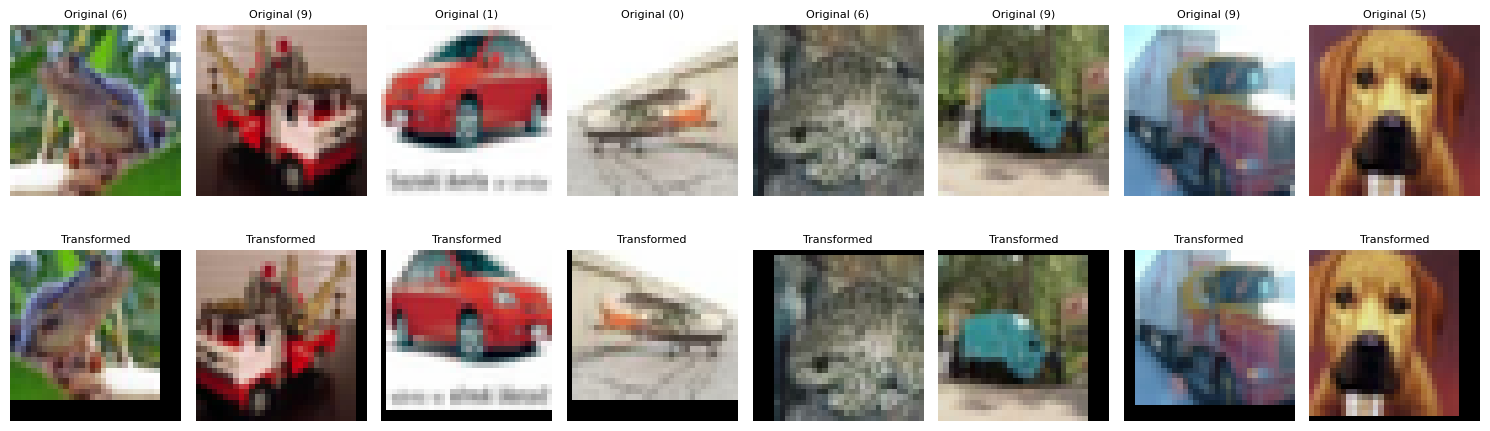

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per visualizzare batch di immagini originali e trasformate
def show_batch_comparison(dataloader, num_images=8):
    data_iter = iter(dataloader)
    transformed_images, original_images, labels = next(data_iter)  # Prendi un batch

    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Immagine originale
        orig_img = original_images[i] #/ 255.0  # Normalizza tra 0 e 1 per visualizzazione
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f"Original ({labels[i]})", fontsize=8)
        axes[0, i].axis("off")

        # Immagine trasformata
        trans_img = transformed_images[i].numpy().transpose((1, 2, 0))  # Converti da Tensor a numpy
        trans_img = trans_img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])  # Denormalizza
        trans_img = np.clip(trans_img, 0, 1)  # Clippa i valori tra 0 e 1

        axes[1, i].imshow(trans_img)
        axes[1, i].set_title("Transformed", fontsize=8)
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualizza il confronto tra immagini originali e trasformate
show_batch_comparison(BrokenLoader)

> **EXERCISE** *(discuss only)*
>
> Consider [The Abstraction and Reasoning Corpus (ARC)](https://github.com/fchollet/ARC).
>
> If you want, you can clone the ARC repository on your computer and play against some proposed tasks (without writing any program -- play yourself as a human!). It is enough to open `apps/testing_interface.html` in your browser.
>
> > *ARC can be seen as a general artificial intelligence benchmark, as a program synthesis benchmark, or as a psychometric intelligence test. It is targeted at both humans and artificially intelligent systems that aim at emulating a human-like form of general fluid intelligence.*
> >
> > **Dataset goal**
> >
> > A test-taker is said to solve a task when, upon seeing the task for the first time, they are able to produce the correct output grid for *all* test inputs in the task (this includes picking the dimensions of the output grid). For each test input, the test-taker is allowed 3 trials (this holds for all test-takers, either humans or AI).
> >
> > **Task file format**
> >
> > The `data` directory contains two subdirectories:
> >
> > - `data/training`: contains the task files for training (400 tasks). Use these to prototype your algorithm or to train your algorithm to acquire ARC-relevant cognitive priors.
> > - `data/evaluation`: contains the task files for evaluation (400 tasks). Use these to evaluate your final algorithm. To ensure fair evaluation results, do not leak information from the evaluation set into your algorithm, e.g. by looking at the evaluation tasks yourself during development, or by repeatedly modifying an algorithm while using its evaluation score as feedback (remember that [this is conceptually wrong](#data-leakage)!).
> >
> > The tasks are stored in JSON format. Each task JSON file contains a dictionary with two fields:
> >
> > - `"train"`: demonstration input/output pairs. It is a list of "pairs" (typically 3 pairs).
> > - `"test"`: test input/output pairs. It is a list of "pairs" (typically 1 pair).
> >
> > A "pair" is a dictionary with two fields:
> >
> > - `"input"`: the input "grid" for the pair.
> > - `"output"`: the output "grid" for the pair.
> >
> > A "grid" is a rectangular matrix (list of lists) of integers between 0 and 9 (inclusive). The smallest possible grid size is 1x1 and the largest is 30x30.
>
>
> - What would your`Dataset` return for this task?
> - What would each batch contain?
>
> Discuss and compare your choices with your colleagues. Did you all make the same choices? Why or why not?


✏️ Write down your conclusions here